In [36]:
from typing import Dict

import pandas as pd
from IPython.display import Image


import spacy
import neo4j

## neo4j desktop で作成したDBMSに接続する
- 接続情報を設定する

In [2]:
URI = "bolt://localhost:7687"
USER = "neo4j"
PASS = "password"

- `GraphDatabase` を使ってDBMSに接続する

In [3]:
driver = neo4j.GraphDatabase.driver(uri=URI, auth=(USER, PASS), encrypted=0)

## CSVファイルを読み込む
- 予め `MASC Sentence Corpus (tab-separated format)` をダウンロード・解凍しておく
  - http://www.anc.org/data/masc/downloads/data-download/
- `MASC Sentence Corpus` 内の `masc_sentences.tsv` を所定の場所に移動しておく
  - MacOSだと `/Users/username/Library/Application\ Support/com.Neo4j.Relate/Data/dbmss/dbms-[DBMS ID]/import/`

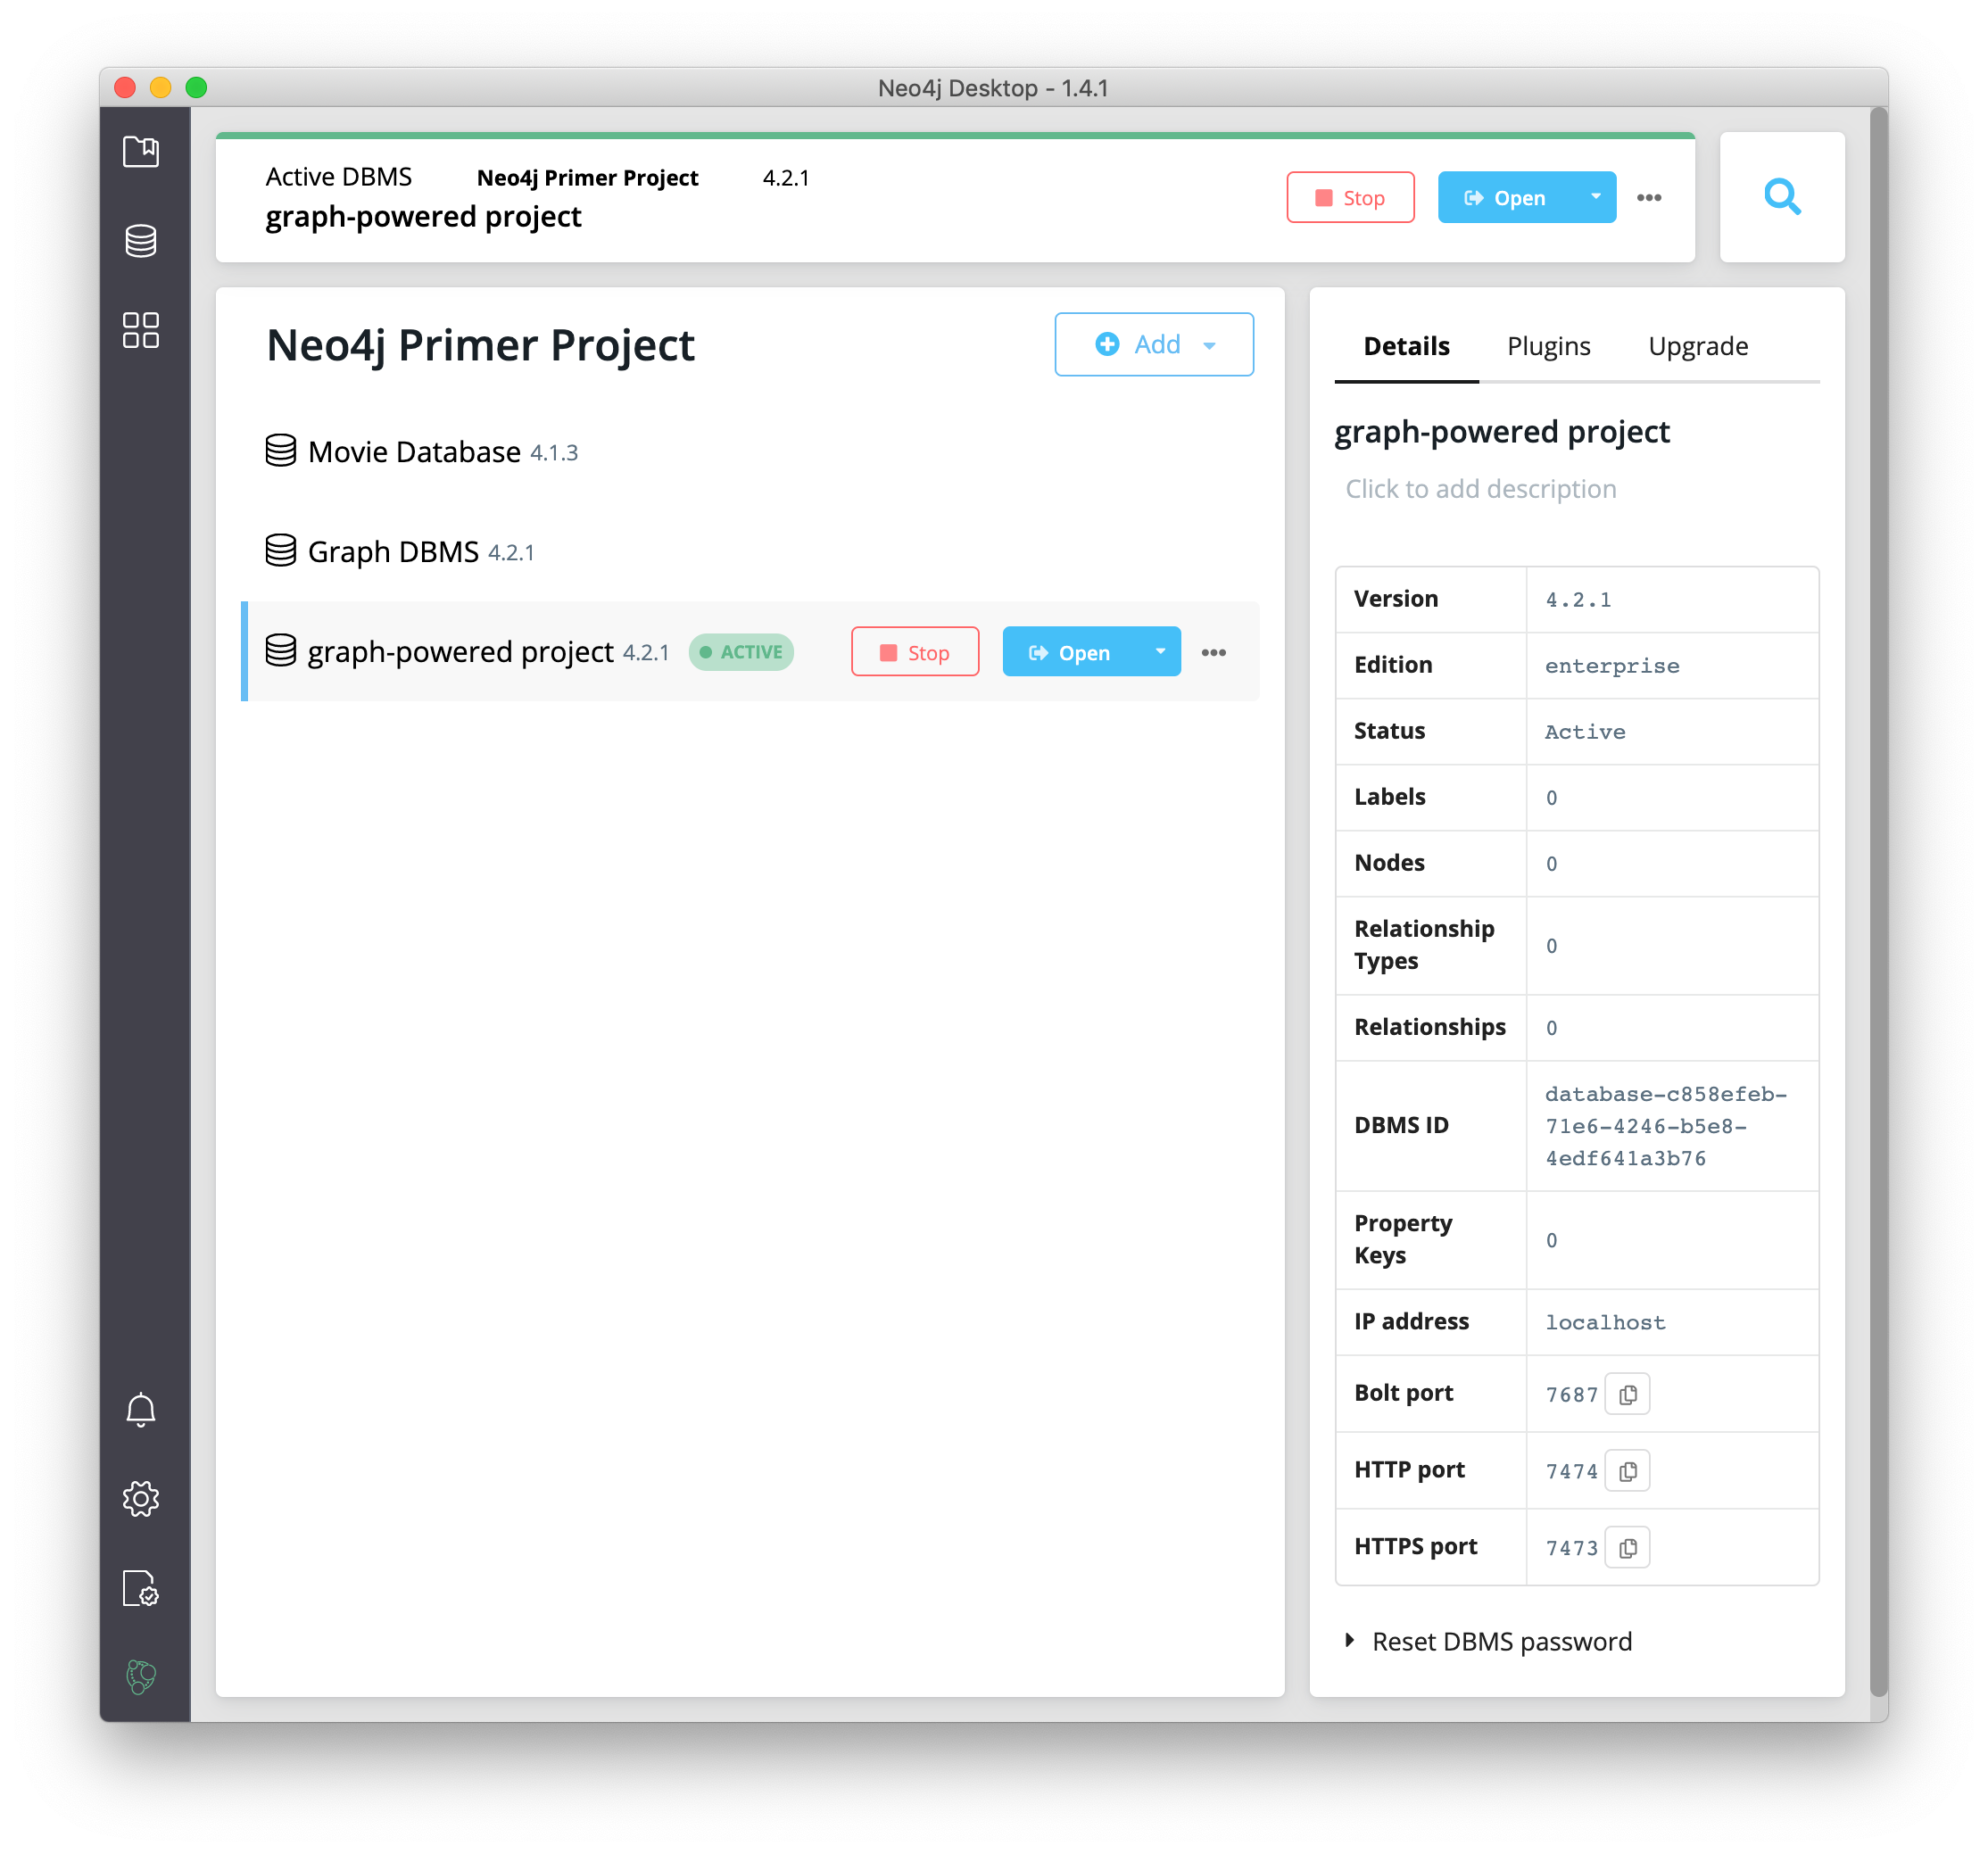

In [4]:
Image("images/neo4j_desktop.png")

- 接続したDBMSへ `masc_sentences.tsv` を読み込む
  - `Set 2380249 properties, completed after 249025 ms.`

In [5]:
query = """USING PERIODIC COMMIT 1000
LOAD CSV FROM "file:///masc_sentences.tsv" AS line
FIELDTERMINATOR '\t'
WITH line[6] as sentence
WITH split(sentence, " ") as words
FOREACH ( idx IN range(0,size(words)-2) |  
MERGE (w1:Word {value:words[idx]})
MERGE (w2:Word {value:words[idx+1]})
MERGE (w1)-[r:NEXT]->(w2)
  ON CREATE SET r.weight = 1
  ON MATCH SET r.weight = r.weight + 1)
"""

"""
with driver.session() as session:
    result = session.run(query)
"""

'\nwith driver.session() as session:\n    result = session.run(query)\n'

# Cypher クエリの実行
- helper関数を定義しておく

In [37]:
def execute_cypher_query(driver: neo4j.BoltDriver, query: str) -> pd.DataFrame:
    with driver.session() as session:
        result = session.run(query)
        result = list(result)
    df = pd.DataFrame([dict(r) for r in result])
    return df

- Find the top 10 most common couple of words

In [38]:
query = """
MATCH (w1:Word)-[r:NEXT]->(w2)
RETURN w1.value as first, w2.value as second, r.weight as frequency
ORDER by r.weight DESC
LIMIT 10
"""
df = execute_cypher_query(driver, query)
df.head(n=10)

,first,second,frequency
0,mail,until,None
1,new,mail,None
2,send,new,None
3,to,send,None
4,You,will,None
5,not,be,None
6,will,not,None
7,able,to,None
8,be,able,None
9,until,you,None


- Query that suggest the most probable word

In [39]:
query = """
MATCH (w:Word {value: "how"})-[e:NEXT]->(w2:Word)
RETURN w2.value as next, e.weight as frequency
ORDER BY frequency desc
LIMIT 3
"""
df = execute_cypher_query(driver, query)
df.head(n=3)

,next,frequency
0,to,812
1,the,507
2,much,357


- Cleaning up the database using APOC’s iterate procedure

In [8]:
# pass

- New importing query which uses the sentence identifier

In [9]:
# pass

- Query to suggest the next word considering the last two words

In [40]:
query = """
MATCH (w2:Word {value: "know"})-[r:NEXT]->(w3:Word {value: "how"})-[e:NEXT]->(w4:Word)
WHERE r.sentence = e.sentence
RETURN w4.value as next, count(DISTINCT r) as frequency
ORDER BY frequency desc
LIMIT 3
"""
df = execute_cypher_query(driver, query)
df.head(n=3)

""


- Query 11.11 Query to suggest the next word considering the last three words

In [42]:
query = """
MATCH (w1:Word {value: "you"})-[a:NEXT]->(w2:Word {value: "know"})-[r:NEXT]->(w3:Word {value: "how"})-[e:NEXT]->(w4:Word2)
WHERE a.sentence = r.sentence AND r.sentence = e.sentence
RETURN w4.value as next, count(DISTINCT r) as frequency
ORDER BY frequency desc
LIMIT 3
"""
df = execute_cypher_query(driver, query)
df.head(n=3)

""


## NLP

- Basic text processing with spaCy

In [13]:
nlp = spacy.load("en_core_web_sm")

- Creating the first graph out of text

In [43]:
def execute_query(query: str, params: Dict[str, str]):
    with driver.session() as session:
        result = session.run(query, parameters=params)
        result = list(result)
    return result

def tokenize_and_store(text, text_id, store_tag):
    docs = nlp.pipe([text], disable=["ner"])
    for doc in docs:
        annotated_text = create_annotated_text(doc, text_id)
        i = 1
        for sentence in doc.sents:
            sentence_id = store_sentence(sentence, annotated_text, text_id, i, store_tag)
            i += 1

def create_annotated_text(self, doc, doc_id):
    query = """
    MERGE (ann:AnnotatedText {id: {doc_id}})
    RETURN id(ann) as result
    """
    params = {"id": doc_id}
    results = execute_query(query, params)
    return results[0]
 
def store_sentence(self, sentence, annotated_text, text_id, sentence_id, storeTag):
    sentence_query = """
    MATCH (ann:AnnotatedText) WHERE id(ann) = {ann_id}
    MERGE (sentence:Sentence {id: {sentence_unique_id}})
    SET sentence.text = {text}
    MERGE (ann)-[:CONTAINS_SENTENCE]->(sentence)
    RETURN id(sentence) as result
    """
 
    tag_occurrence_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = {sentence_id}
    WITH sentence, {tag_occurrences} as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    RETURN id(sentence) as result
    """
 
    tag_occurrence_with_tag_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = {sentence_id}
    WITH sentence, {tag_occurrences} as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    FOREACH (tagItem in [tag_occurrence IN {tag_occurrences} WHERE tag_occurrence.is_stop = False] |
    MERGE (tag:Tag {id: tagItem.lemma}) MERGE (tagOccurrence:TagOccurrence {id: tagItem.id}) MERGE (tag)<-[:REFERS_TO]-(tagOccurrence))
    RETURN id(sentence) as result
    """
 
    params = {
        "ann_id": annotated_text, 
        "text": sentence.text, 
        "sentence_unique_id": str(text_id) + "_" + str(sentence_id)
    }
    results = execute_query(sentence_query, params)
    
    node_sentence_id = results[0]
    tag_occurrences = []
    for token in sentence:
        lexeme = self.nlp.vocab[token.text]
        if not lexeme.is_punct and not lexeme.is_space:
            tag_occurrence = {
                "id": str(text_id) + "_" + str(sentence_id) + "_" + str(token.idx),
                "index": token.idx,
                "text": token.text,
                "lemma": token.lemma_,
                "pos": token.tag_,
                "is_stop": (lexeme.is_stop or lexeme.is_punct or lexeme.is_space)
            }
            tag_occurrences.append(tag_occurrence)
    params = {
        "sentence_id": node_sentence_id, 
        "tag_occurrences":tag_occurrences
    }
    if store_tag:
        results = execute_query(tag_occurrence_with_tag_query, params)
    else:
        results = execute_query(tag_occurrence_query, params)
    return results[0]

- Extracting and storing the dependencies

In [ ]:
def store_sentence(self, sentence, annotated_text, text_id, sentence_id, store_tag):
    sentence_query = """
    MATCH (ann:AnnotatedText) WHERE id(ann) = {ann_id}
    MERGE (sentence:Sentence {id: {sentence_unique_id}})
    SET sentence.text = {text}
    MERGE (ann)-[:CONTAINS_SENTENCE]->(sentence)
    RETURN id(sentence) as result
    """
 
    tag_occurrence_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = {sentence_id}
    WITH sentence, {tag_occurrences} as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    RETURN id(sentence) as result
    """
 
    tag_occurrence_with_tag_query = """
    MATCH (sentence:Sentence) WHERE id(sentence) = {sentence_id}
    WITH sentence, {tag_occurrences} as tags
    FOREACH ( idx IN range(0,size(tags)-2) |
    MERGE (tagOccurrence1:TagOccurrence {id: tags[idx].id})
    SET tagOccurrence1 = tags[idx]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence1)
    MERGE (tagOccurrence2:TagOccurrence {id: tags[idx + 1].id})
    SET tagOccurrence2 = tags[idx + 1]
    MERGE (sentence)-[:HAS_TOKEN]->(tagOccurrence2)
    MERGE (tagOccurrence1)-[r:HAS_NEXT {sentence: sentence.id}]->(tagOccurrence2))
    FOREACH (tagItem in [tag_occurrence IN {tag_occurrences} WHERE tag_occurrence.is_stop = False] |
    MERGE (tag:Tag {id: tagItem.lemma}) MERGE (tagOccurrence:TagOccurrence {id: tagItem.id}) MERGE (tag)<-[:REFERS_TO]-(tagOccurrence))
    RETURN id(sentence) as result
    """  
    
    params = {
        "ann_id": annotated_text, 
        "text": sentence.text, 
        "sentence_unique_id": str(text_id) + "_" + str(sentence_id)
    }
    results = execute_query(sentence_query, params)
    
    node_sentence_id = results[0]
    tag_occurrences = []
    tag_occurrence_dependencies = []
    for token in sentence:
        lexeme = nlp.vocab[token.text]
        if not lexeme.is_punct and not lexeme.is_space:
            tag_occurrence_id = str(text_id) + "_" + str(sentence_id) + "_" + str(token.idx)
            tag_occurrence = {
                "id": tag_occurrence_id,
                "index": token.idx,
                "text": token.text,
                "lemma": token.lemma_,
                "pos": token.tag_,
                "is_stop": (lexeme.is_stop or lexeme.is_punct or lexeme.is_space)
            }
            tag_occurrences.append(tag_occurrence)
            tag_occurrence_dependency_source = str(text_id) + "_" + str(sentence_id) + "_" + str(token.head.idx)
            
            dependency = {
                "source": tag_occurrence_dependency_source, 
                "destination": tag_occurrence_id, 
                "type": token.dep_
            }
            tag_occurrence_dependencies.append(dependency)
            
    params = {
        "sentence_id": node_sentence_id, 
        "tag_occurrences":tag_occurrences
    }
    if store_tag:
        results = execute_query(tag_occurrence_with_tag_query, params)
    else:
        results = execute_query(tag_occurrence_query, params)
 
    process_dependencies(tag_occurrence_dependencies)
    return results[0]
 
def process_dependencies(self, tag_occurrence_dependencies):
    tag_occurrence_query = """
    UNWIND {dependencies} as dependency
    MATCH (source:TagOccurrence {id: dependency.source})
    MATCH (destination:TagOccurrence {id: dependency.destination})
    MERGE (source)-[:IS_DEPENDENT {type: dependency.type}]->(destination)
    """
    execute_query(tag_occurrence_query, {"dependencies": tag_occurrence_dependencies})

- Searching for documents with the word “apples”

In [44]:
query = """
WITH  "apples" as searchQuery
MATCH (t:TagOccurrence)<-[*2..2]-(at:AnnotatedText)
WHERE t.lemma = searchQuery OR t.text = searchQuery
RETURN at
"""
df = execute_cypher_query(driver, query)
df.head()

""


- Searching for “small apples”

In [45]:
query = """
WITH  "small" as firstWord, "apples" as secondWord
MATCH (t0:TagOccurrence)-[:HAS_NEXT*..2]-(t1:TagOccurrence)
WHERE (t0.lemma = firstWord or t0.text = firstWord) AND (t1.lemma = secondWord or t1.text = secondWord)
MATCH (t1)-[:IS_DEPENDENT]->(t0)<-[*2..2]-(at:AnnotatedText)
return at
"""
df = execute_cypher_query(driver, query)
df.head()

""


- Answering the question “What are the apples like?”

In [46]:
query = """
WITH  "apples" as searchQuery
MATCH (t0:TagOccurrence)
WHERE (t0.lemma = searchQuery or t0.text = searchQuery)
MATCH (t0)-[:IS_DEPENDENT {type: "amod"}]->(t1:TagOccurrence)
return t1.text
"""
df = execute_cypher_query(driver, query)
df.head()

""
